In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
%matplotlib inline 

In [2]:
# There are some Nan values -> substitute them
def detect_NANs(df):
  # detect features with NAN values in a data frame
  features = list(df)
  NAN_features = []
  for feature in features:
    has_NAN = df[[feature]].isna().values.any()
    if has_NAN:
      NAN_features.append(feature)
  return NAN_features

def detect_numeric_categorical_NANs(df, NAN_features):
  categoricals = []
  numericals = []
  for feature in NAN_features:
    if df[feature].dtype == 'object':
      categoricals.append(feature)
    else:
      numericals.append(feature)
  return [numericals, categoricals]


def fill_numeric_NANs(df, features, mean_fill):
  for f in features:
    if mean_fill:
      df[f].fillna(df[f].mean(), inplace=True)

def fill_categorical_NANs(df, features, fill_value):
  for f in features:
    df[f].fillna(fill_value, inplace=True)

def sift_NANs(df, ordinal_mean_fill, categorical_fill_value):
  print(f'------------NAN processing----------------\n')
  NAN_features = detect_NANs(df)
  NAN_features_numeric, NAN_features_categorical = detect_numeric_categorical_NANs(df, NAN_features)
  print(f'{len(NAN_features_numeric)} numeric features with NAN:\n{NAN_features_numeric}\n\n',
      f'{len(NAN_features_categorical)} categorical features with NAN:\n {NAN_features_categorical}\n')
  
  # Step 2: Eliminate NAN values
  fill_numeric_NANs(df, NAN_features_numeric, ordinal_mean_fill)
  fill_categorical_NANs(df, NAN_features_categorical, categorical_fill_value)

  NAN_features = detect_NANs(df)
  print(f'After processing remain {len(NAN_features)} NAN values\n',
        f'------------------------------------------------------')
  return

def get_categorical_features(df, features):
  categoricals = []
  for feature in features:
    if df[feature].dtype == 'object':
      categoricals.append(feature)
  return categoricals

def encode_categoricals(df, categorical_features):
  encoder = LabelEncoder()
  for feature in categorical_features:
    df[feature] = encoder.fit_transform(df[feature].values)


  
def drop_minor_features(df, features_to_drop):
  df_features = df.columns
  for f in features_to_drop:
    if f in df_features:
      df.drop(f, axis=1, inplace=True)
  
def get_insignificant_features(df_correlation, corr_threshold, corr_feature):
  correlations = df_correlation[corr_feature]
  res = []
  for feature in correlations.index:
    if correlations[feature] < corr_threshold:
      res.append(feature)
  return res

def check_if_features_remained(df_features, features_to_check):
  if any(f in df_features for f in features_to_check):
    return True
  return False

In [3]:
def prepare_dataset(df, 
                     corr_threshold,
                     categorical_fill_value='None',
                     ordinal_mean_fill=True, 
                     plot_distrib=True,
                     features_to_drop=None):
  print(f'-------------------------------------------------\n')

  print(f'STEP1: Look at initial features:\n')
  print(df_train.info())
  
  print(f'-------------------------------------------------\n')
  
  if plot_distrib:
    print(f'STEP2: SALES DISTRIBUTION\n')
    sns.distplot(df['SalePrice'])

  print(f'-------------------------------------------------\n')

  print(f'STEP3: SIFT NAN VALUES')
  sift_NANs(df, ordinal_mean_fill=True, categorical_fill_value='None')

  print(f'-------------------------------------------------\n')

  print(f'STEP4: ALL CATEGORICAL TO ORDINAL ENCODE\n')
  categorical_features = get_categorical_features(df, list(df))
  print(f'{len(categorical_features)} categorical features, \n{categorical_features}\n')
  encode_categoricals(df, categorical_features)
  categorical_features_after = get_categorical_features(df, list(df))
  print(f'AFTER ENCODING: {len(categorical_features_after)} categorical features, \n{categorical_features_after}')

  print(f'-------------------------------------------------\n')

  print(f'STEP5: HEATMAP TO IDENTIFY LESS SIGNIFICANT FEATURES')
  df_correlation = df_train.corr()
  sns.heatmap(df_correlation)

  print(f'-------------------------------------------------\n')

  print(f'STEP6: REMOVE INSIGNIFICANT FEATURES')

  if features_to_drop is None:
    features_to_drop = get_insignificant_features(df_correlation, corr_threshold, 
                                              corr_feature='SalePrice')
    print(f'{len(features_to_drop)} insignificant features, for level={corr_threshold}\n',
        f'features_to_drop = {features_to_drop}')
  drop_minor_features(df, features_to_drop)

  print(f'-------------------------------------------------\n')

  print(f'STEP7: MAKE SURE NO INSIGNIFICANT FEATURE IS IN DATASET')
  features = df.columns
  check = check_if_features_remained(features, features_to_drop) 
  print(f'If any insignif. features remained? --> {check}')

  print(f'-------------------------------------------------\n')

  print(f'STEP8: Your dataset after processing:')
  print(df.info())

  print(f'-----------------------END-----------------------\n')
  return features_to_drop






In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
downloaded_test = drive.CreateFile({'id':"1hFI_R74GXe0I6sh8AeCacyAritHN9GUT"})   
downloaded_test.GetContentFile('test.csv')

downloaded_train = drive.CreateFile({'id':"1fYsLA8QtArP_HSlraZU4x0a5IQnRNeN0"})   
downloaded_train.GetContentFile('train.csv')

In [6]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

-------------------------------------------------

STEP1: Look at initial features:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


After processing remain 0 NAN values
 ------------------------------------------------------
-------------------------------------------------

STEP4: ALL CATEGORICAL TO ORDINAL ENCODE

43 categorical features, 
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

AFTER ENCODING: 0 categorical features, 
[]
-------------------------------------------------

STEP5: HEATMAP TO IDENTIFY LESS SIGNIFICANT FEATURES
-------------------------------------------------

STEP6: R

['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature']

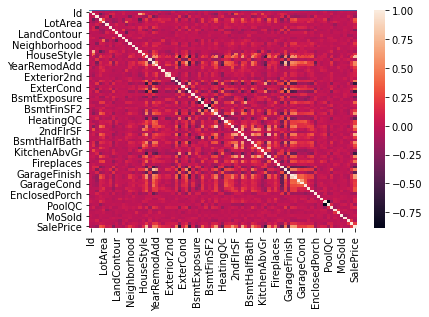

In [7]:
prepare_dataset(df_train, 
                corr_threshold=-0.2, 
                features_to_drop = [
                  'Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature'
                ])

-------------------------------------------------

STEP1: Look at initial features:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   int64  
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   int64  
 5   LotShape       1460 non-null   int64  
 6   LandContour    1460 non-null   int64  
 7   Utilities      1460 non-null   int64  
 8   LotConfig      1460 non-null   int64  
 9   LandSlope      1460 non-null   int64  
 10  Neighborhood   1460 non-null   int64  
 11  Condition1     1460 non-null   int64  
 12  Condition2     1460 non-null   int64  
 13  BldgType       1460 non-null   int64  
 14  HouseStyle     1460 non-null   int64  
 15  OverallQual    1460 non-null   int64  
 16  OverallCond

['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature']

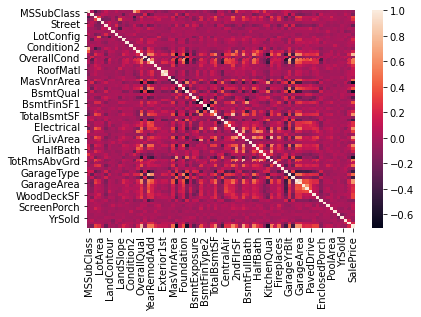

In [8]:
prepare_dataset(df_test, 
                corr_threshold=-0.2, 
                plot_distrib=False,
                features_to_drop = [
                  'Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature'
                ])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


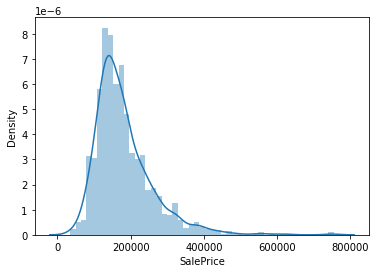

In [9]:
sns.distplot(df_train['SalePrice'])

0    1459
1       1
Name: Utilities, dtype: int64


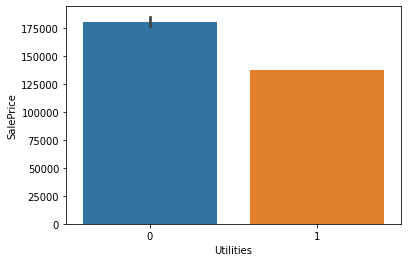

In [10]:
print(df_train['Utilities'].value_counts())
sns.barplot(x='Utilities', y='SalePrice', data=df_train)

In [11]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,3,65.0,8450,1,3,3,0,4,0,5,2,2,0,5,7,5,2003,2003,1,1,12,13,1,196.0,2,4,2,2,4,3,2,706,6,0,150,856,1,0,1,5,856,854,0,1710,1,0,2,1,3,1,2,8,6,0,3,1,2003.0,2,2,548,5,5,2,0,61,0,0,0,0,0,2,2008,8,4,208500
1,20,3,80.0,9600,1,3,3,0,2,0,24,1,2,0,2,6,8,1976,1976,1,1,8,8,2,0.0,3,4,1,2,4,1,0,978,6,0,284,1262,1,0,1,5,1262,0,0,1262,0,1,2,0,3,1,3,6,6,1,5,1,1976.0,2,2,460,5,5,2,298,0,0,0,0,0,0,5,2007,8,4,181500
2,60,3,68.0,11250,1,0,3,0,4,0,5,2,2,0,5,7,5,2001,2002,1,1,12,13,1,162.0,2,4,2,2,4,2,2,486,6,0,434,920,1,0,1,5,920,866,0,1786,1,0,2,1,3,1,2,6,6,1,5,1,2001.0,2,2,608,5,5,2,0,42,0,0,0,0,0,9,2008,8,4,223500
3,70,3,60.0,9550,1,0,3,0,0,0,6,2,2,0,5,7,5,1915,1970,1,1,13,15,2,0.0,3,4,0,4,1,3,0,216,6,0,540,756,1,2,1,5,961,756,0,1717,1,0,1,0,3,1,2,7,6,1,2,5,1998.0,3,3,642,5,5,2,0,35,272,0,0,0,0,2,2006,8,0,140000
4,60,3,84.0,14260,1,0,3,0,2,0,15,2,2,0,5,8,5,2000,2000,1,1,12,13,1,350.0,2,4,2,2,4,0,2,655,6,0,490,1145,1,0,1,5,1145,1053,0,2198,1,0,2,1,4,1,2,9,6,1,5,1,2000.0,2,3,836,5,5,2,192,84,0,0,0,0,0,12,2008,8,4,250000


In [12]:
df_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,3,80.0,11622,1,3,3,0,4,0,12,1,2,0,2,5,6,1961,1961,1,0,11,13,2,0.0,3,4,1,4,4,3,5,468.0,3,144.0,270.0,882.0,0,4,1,3,896,0,0,896,0.0,0.0,1,0,2,1,4,5,7,0,3,1,1961.0,3,1.0,730.0,4,5,2,140,0,0,0,120,0,0,6,2010,9,4
1,20,4,81.0,14267,1,0,3,0,0,0,12,2,2,0,2,6,6,1958,1958,3,0,12,14,1,108.0,3,4,1,4,4,3,0,923.0,6,0.0,406.0,1329.0,0,4,1,3,1329,0,0,1329,0.0,0.0,1,1,3,1,2,6,7,0,3,1,1958.0,3,1.0,312.0,4,5,2,393,36,0,0,0,0,12500,6,2010,9,4
2,60,4,74.0,13830,1,0,3,0,4,0,8,2,2,0,4,5,5,1997,1998,1,0,11,13,2,0.0,3,4,2,2,4,3,2,791.0,6,0.0,137.0,928.0,0,2,1,3,928,701,0,1629,0.0,0.0,2,1,3,1,4,6,7,1,5,1,1997.0,0,2.0,482.0,4,5,2,212,34,0,0,0,0,0,3,2010,9,4
3,60,4,78.0,9978,1,0,3,0,4,0,8,2,2,0,4,6,6,1998,1998,1,0,11,13,1,20.0,3,4,2,4,4,3,2,602.0,6,0.0,324.0,926.0,0,0,1,3,926,678,0,1604,0.0,0.0,2,1,3,1,2,7,7,1,2,1,1998.0,0,2.0,470.0,4,5,2,360,36,0,0,0,0,0,6,2010,9,4
4,120,4,43.0,5005,1,0,1,0,4,0,22,2,2,4,2,8,5,1992,1992,1,0,6,6,2,0.0,2,4,2,2,4,3,0,263.0,6,0.0,1017.0,1280.0,0,0,1,3,1280,0,0,1280,0.0,0.0,2,0,2,1,2,5,7,0,3,1,1992.0,2,2.0,506.0,4,5,2,0,82,0,0,144,0,0,1,2010,9,4


In [13]:
# Step 8 
X_train = df_train.drop('SalePrice', axis=1)
Y_train = df_train['SalePrice']
X_test = df_test

In [14]:
# Step 9 Standardize values
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [15]:
print(X_train)

[[ 0.07337496 -0.04553194 -0.22937175 ...  0.13877749  0.31386709
   0.2085023 ]
 [-0.87256276 -0.04553194  0.4519361  ... -0.61443862  0.31386709
   0.2085023 ]
 [ 0.07337496 -0.04553194 -0.09311018 ...  0.13877749  0.31386709
   0.2085023 ]
 ...
 [ 0.30985939 -0.04553194 -0.18395123 ...  1.64520971  0.31386709
   0.2085023 ]
 [-0.87256276 -0.04553194 -0.09311018 ...  1.64520971  0.31386709
   0.2085023 ]
 [-0.87256276 -0.04553194  0.22483348 ...  0.13877749  0.31386709
   0.2085023 ]]


In [16]:
print(Y_train)

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64


In [17]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=200, random_state=0)
regressor.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [18]:
Y_pred = regressor.predict(X_test)
Y_pred

array([123608.365, 157180.185, 172837.165, ..., 150117.74 , 110846.79 ,
       224484.385])

In [19]:
from sklearn.metrics import accuracy_score

regressor.score(X_train, Y_train)
regressor = round(regressor.score(X_train, Y_train) * 100, 2)
regressor

98.18

In [20]:
df_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,3,80.0,11622,1,3,3,0,4,0,12,1,2,0,2,5,6,1961,1961,1,0,11,13,2,0.0,3,4,1,4,4,3,5,468.0,3,144.0,270.0,882.0,0,4,1,3,896,0,0,896,0.0,0.0,1,0,2,1,4,5,7,0,3,1,1961.0,3,1.0,730.0,4,5,2,140,0,0,0,120,0,0,6,2010,9,4
1,20,4,81.0,14267,1,0,3,0,0,0,12,2,2,0,2,6,6,1958,1958,3,0,12,14,1,108.0,3,4,1,4,4,3,0,923.0,6,0.0,406.0,1329.0,0,4,1,3,1329,0,0,1329,0.0,0.0,1,1,3,1,2,6,7,0,3,1,1958.0,3,1.0,312.0,4,5,2,393,36,0,0,0,0,12500,6,2010,9,4
2,60,4,74.0,13830,1,0,3,0,4,0,8,2,2,0,4,5,5,1997,1998,1,0,11,13,2,0.0,3,4,2,2,4,3,2,791.0,6,0.0,137.0,928.0,0,2,1,3,928,701,0,1629,0.0,0.0,2,1,3,1,4,6,7,1,5,1,1997.0,0,2.0,482.0,4,5,2,212,34,0,0,0,0,0,3,2010,9,4
3,60,4,78.0,9978,1,0,3,0,4,0,8,2,2,0,4,6,6,1998,1998,1,0,11,13,1,20.0,3,4,2,4,4,3,2,602.0,6,0.0,324.0,926.0,0,0,1,3,926,678,0,1604,0.0,0.0,2,1,3,1,2,7,7,1,2,1,1998.0,0,2.0,470.0,4,5,2,360,36,0,0,0,0,0,6,2010,9,4
4,120,4,43.0,5005,1,0,1,0,4,0,22,2,2,4,2,8,5,1992,1992,1,0,6,6,2,0.0,2,4,2,2,4,3,0,263.0,6,0.0,1017.0,1280.0,0,0,1,3,1280,0,0,1280,0.0,0.0,2,0,2,1,2,5,7,0,3,1,1992.0,2,2.0,506.0,4,5,2,0,82,0,0,144,0,0,1,2010,9,4


In [23]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, random_state = 98987)
print(x_train, x_test, y_train, y_test)

[[-8.72562756e-01 -4.55319398e-02  9.51561860e-01 ...  1.38777489e-01
   3.13867092e-01  2.08502298e-01]
 [ 2.43821926e+00  1.53724502e+00 -2.22787479e+00 ... -1.36765473e+00
   3.13867092e-01  2.08502298e-01]
 [ 7.33749635e-02 -4.55319398e-02 -1.83951230e-01 ... -6.14438622e-01
   3.13867092e-01  2.08502298e-01]
 ...
 [ 2.43821926e+00 -3.21108585e+00  6.45464462e-16 ... -6.14438622e-01
   3.13867092e-01  2.08502298e-01]
 [ 5.46343823e-01 -4.55319398e-02  6.45464462e-16 ...  1.64520971e+00
   3.13867092e-01  2.08502298e-01]
 [ 7.33749635e-02 -4.55319398e-02  1.26950552e+00 ...  8.91993600e-01
   3.13867092e-01  2.08502298e-01]] [[ 7.33749635e-02 -4.55319398e-02  6.45464462e-16 ...  8.91993600e-01
   3.13867092e-01  2.08502298e-01]
 [ 7.33749635e-02 -3.21108585e+00  6.79038718e-01 ...  8.91993600e-01
   3.13867092e-01  2.08502298e-01]
 [-6.36078326e-01  1.53724502e+00 -4.56474371e-01 ... -6.14438622e-01
   3.13867092e-01  2.08502298e-01]
 ...
 [-1.63109466e-01 -4.79386281e+00  1.5874491

In [25]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=200, random_state=0)
regressor.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [26]:
y_pred = regressor.predict(x_test)

In [43]:
len(y_pred), len(y_test)
#y_test.values
for i in range(0, 15):
  print(f'{y_pred[i]}, {y_test.values[i]}\n')

177588.63, 178000

346187.965, 310000

113159.67, 102000

136283.385, 124000

170826.325, 178000

142715.375, 156000

239718.15, 272000

160245.825, 184000

230296.905, 222000

115229.705, 125500

213260.975, 231500

246467.18, 268000

93522.63, 75000

364776.67, 335000

123431.58, 130250



In [50]:
type(y_pred), type(y_test.values)
list(y_pred)
list(y_test)

[178000,
 310000,
 102000,
 124000,
 178000,
 156000,
 272000,
 184000,
 222000,
 125500,
 231500,
 268000,
 75000,
 335000,
 130250,
 190000,
 171900,
 160000,
 348000,
 197500,
 276000,
 111250,
 144000,
 146800,
 319000,
 95000,
 165150,
 235000,
 150000,
 394432,
 180000,
 372402,
 239799,
 184000,
 219500,
 208500,
 105900,
 289000,
 171000,
 109500,
 124900,
 175900,
 161000,
 120000,
 125000,
 375000,
 135000,
 189000,
 120000,
 301000,
 177500,
 117500,
 318000,
 193500,
 164700,
 128000,
 119500,
 274000,
 185000,
 204750,
 106500,
 178400,
 157500,
 211000,
 213500,
 143000,
 136500,
 58500,
 227875,
 159000,
 190000,
 140000,
 163000,
 207500,
 131500,
 147500,
 117000,
 335000,
 37900,
 161500,
 197900,
 137000,
 275000,
 143000,
 225000,
 105000,
 198500,
 165600,
 106000,
 178000,
 138800,
 103000,
 79900,
 197900,
 119000,
 140000,
 199900,
 156000,
 275500,
 260000,
 173000,
 108959,
 305000,
 239000,
 90000,
 201800,
 155000,
 219500,
 80000,
 333168,
 179900,
 160000,

In [51]:
from sklearn.metrics import accuracy_score

accuracy_score(list(y_pred), list(y_test.values))

ValueError: ignored